In [1]:
%matplotlib inline
%load_ext autotime

import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


time: 17.7 s


In [3]:
import libs.yellowfin as yf

time: 19.4 ms


In [4]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 936 µs


In [5]:
class OptimizerWrapper( keras.optimizers.Optimizer ):
    def __init__( self, optimizer ):
        self.optimizer = optimizer
        self.updates = []
    def get_updates( self, params, constrains, loss ):
        grads = self.optimizer._optimizer.compute_gradients( loss, params, gate_gradients=yf.GATE_OP )
        opt_update = self.optimizer.apply_gradients( grads )
        self.updates.append( opt_update )
        return self.updates
    @property
    def weights( self ):
        raise NotImplementedError
    def get_config( self ):
        raise NotImplementedError
    def from_config( self ):
        raise NotImplementedError

time: 13.6 ms


# load data

In [6]:
rdf = pd.read_csv( 'datasets/winequality-red.csv', sep=';' )
wdf = pd.read_csv( 'datasets/winequality-white.csv', sep=';' )
df = rdf.append( wdf )

time: 27.7 ms


In [7]:
data_x = df.drop( 'quality', axis=1 ).values
data_y = df.quality.values - df.quality.min()

time: 3.3 ms


In [8]:
train_x, train_y = data_x, data_y
nn_train_x = train_x.astype( float ).reshape( train_x.shape[ 0 ], -1 )
nn_train_x = sk.preprocessing.MinMaxScaler().fit_transform( nn_train_x )
nn_train_y = keras.utils.to_categorical( train_y )

time: 5.21 ms


# parameters

In [9]:
hidden_dim = 128
batch_size = 10000
epochs = 10000

time: 2.32 ms


# YellowFin

In [10]:
m1 = keras.models.Sequential()
m1.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'softmax' ) )
m1.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 176 ms


In [11]:
h1 = m1.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 5min 53s


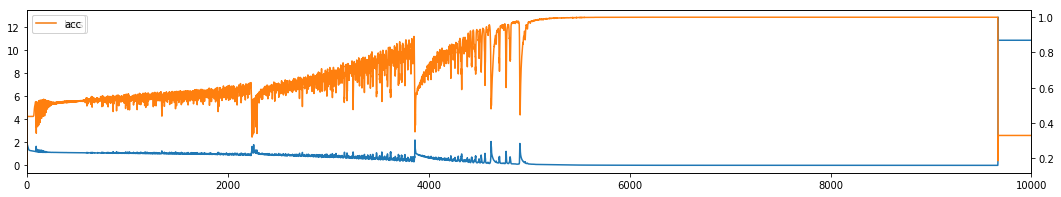

time: 418 ms


In [12]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h1.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h1.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [13]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.32907495767277206

time: 55.3 ms


In [14]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[   0,    0,   30,    0,    0,    0,    0],
       [   0,    0,  216,    0,    0,    0,    0],
       [   0,    0, 2138,    0,    0,    0,    0],
       [   0,    0, 2836,    0,    0,    0,    0],
       [   0,    0, 1079,    0,    0,    0,    0],
       [   0,    0,  193,    0,    0,    0,    0],
       [   0,    0,    5,    0,    0,    0,    0]])

time: 16.5 ms


In [15]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.00      0.00      0.00       216
          2       0.33      1.00      0.50      2138
          3       0.00      0.00      0.00      2836
          4       0.00      0.00      0.00      1079
          5       0.00      0.00      0.00       193
          6       0.00      0.00      0.00         5

avg / total       0.11      0.33      0.16      6497

time: 14.5 ms


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# stochastic gradient descent

In [16]:
m2 = keras.models.Sequential()
m2.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 63.1 ms


In [17]:
h2 = m2.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 4min 41s


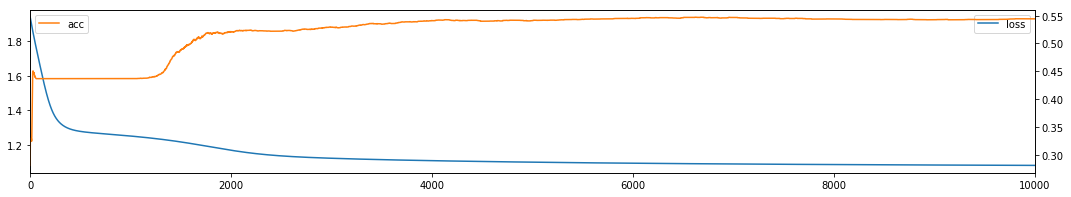

time: 433 ms


In [18]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h2.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h2.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [19]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.54440511005079273

time: 66.7 ms


In [20]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[   0,    0,   16,   14,    0,    0,    0],
       [   0,    0,  136,   78,    2,    0,    0],
       [   0,    0, 1284,  845,    9,    0,    0],
       [   0,    0,  652, 2017,  167,    0,    0],
       [   0,    0,   67,  776,  236,    0,    0],
       [   0,    0,   10,  125,   58,    0,    0],
       [   0,    0,    0,    2,    3,    0,    0]])

time: 19.9 ms


In [21]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.00      0.00      0.00       216
          2       0.59      0.60      0.60      2138
          3       0.52      0.71      0.60      2836
          4       0.50      0.22      0.30      1079
          5       0.00      0.00      0.00       193
          6       0.00      0.00      0.00         5

avg / total       0.51      0.54      0.51      6497

time: 17.7 ms


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Adam

In [22]:
m3 = keras.models.Sequential()
m3.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'softmax' ) )
m3.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 74.1 ms


In [23]:
h3 = m3.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 4min 52s


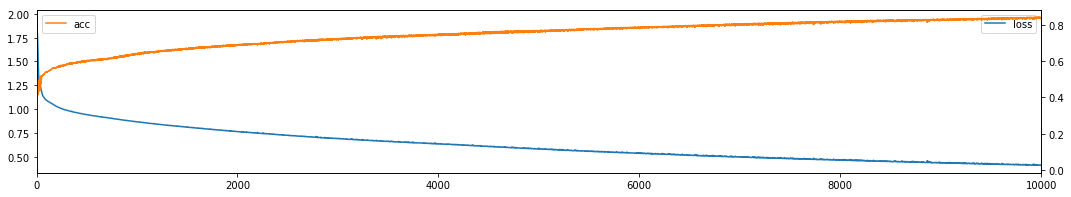

time: 468 ms


In [24]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h3.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h3.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [25]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.83961828536247496

time: 89 ms


In [26]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[  27,    0,    2,    0,    1,    0,    0],
       [   0,  168,   26,   22,    0,    0,    0],
       [   0,    4, 1783,  324,   26,    1,    0],
       [   0,    3,  201, 2500,  129,    3,    0],
       [   0,    0,   17,  237,  820,    5,    0],
       [   0,    0,    0,   20,   21,  152,    0],
       [   0,    0,    0,    0,    0,    0,    5]])

time: 17.5 ms


In [27]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        30
          1       0.96      0.78      0.86       216
          2       0.88      0.83      0.86      2138
          3       0.81      0.88      0.84      2836
          4       0.82      0.76      0.79      1079
          5       0.94      0.79      0.86       193
          6       1.00      1.00      1.00         5

avg / total       0.84      0.84      0.84      6497

time: 14.5 ms


# Nesterov Adam

In [28]:
m4 = keras.models.Sequential()
m4.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'softmax' ) )
m4.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 73.2 ms


In [29]:
h4 = m4.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 4min 56s


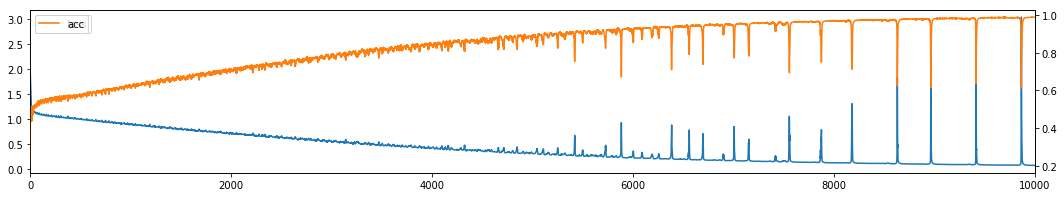

time: 447 ms


In [30]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h4.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h4.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [31]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.98937971371402189

time: 114 ms


In [32]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[  30,    0,    0,    0,    0,    0,    0],
       [   0,  215,    0,    1,    0,    0,    0],
       [   0,    0, 2105,   32,    1,    0,    0],
       [   0,    0,   16, 2812,    8,    0,    0],
       [   0,    0,    2,    9, 1068,    0,    0],
       [   0,    0,    0,    0,    0,  193,    0],
       [   0,    0,    0,    0,    0,    0,    5]])

time: 18.4 ms


In [33]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        30
          1       1.00      1.00      1.00       216
          2       0.99      0.98      0.99      2138
          3       0.99      0.99      0.99      2836
          4       0.99      0.99      0.99      1079
          5       1.00      1.00      1.00       193
          6       1.00      1.00      1.00         5

avg / total       0.99      0.99      0.99      6497

time: 13.8 ms


# YellowFin (BN)

In [34]:
m5 = keras.models.Sequential()
m5.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.Activation( 'softmax' ) )
m5.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 167 ms


In [35]:
h5 = m5.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 14min 58s


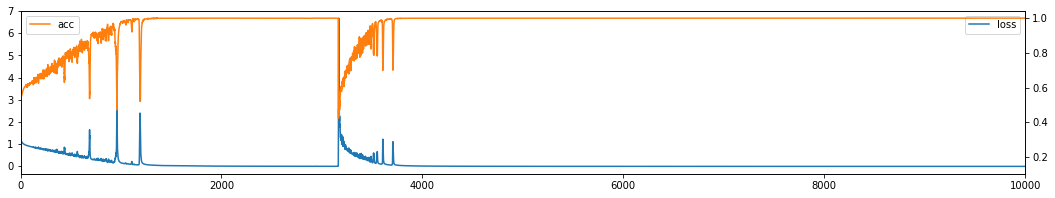

time: 420 ms


In [36]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h5.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h5.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [37]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 228 ms


In [38]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[  30,    0,    0,    0,    0,    0,    0],
       [   0,  216,    0,    0,    0,    0,    0],
       [   0,    0, 2138,    0,    0,    0,    0],
       [   0,    0,    0, 2836,    0,    0,    0],
       [   0,    0,    0,    0, 1079,    0,    0],
       [   0,    0,    0,    0,    0,  193,    0],
       [   0,    0,    0,    0,    0,    0,    5]])

time: 35.8 ms


In [39]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        30
          1       1.00      1.00      1.00       216
          2       1.00      1.00      1.00      2138
          3       1.00      1.00      1.00      2836
          4       1.00      1.00      1.00      1079
          5       1.00      1.00      1.00       193
          6       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00      6497

time: 32.6 ms


# stochastic gradient descent (BN)

In [40]:
m6 = keras.models.Sequential()
m6.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.Activation( 'softmax' ) )
m6.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 160 ms


In [41]:
h6 = m6.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 12min 56s


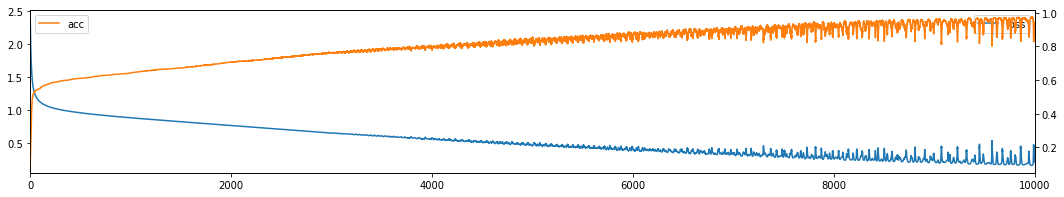

time: 489 ms


In [42]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h6.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h6.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [43]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.92842850546406031

time: 341 ms


In [44]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[  18,    1,    9,    2,    0,    0,    0],
       [   0,  168,   33,   12,    3,    0,    0],
       [   0,    0, 2106,   30,    2,    0,    0],
       [   0,    7,  194, 2610,   25,    0,    0],
       [   0,    0,    6,   80,  987,    6,    0],
       [   0,    0,    4,   27,   20,  142,    0],
       [   0,    0,    0,    2,    1,    1,    1]])

time: 40.2 ms


In [45]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      0.60      0.75        30
          1       0.95      0.78      0.86       216
          2       0.90      0.99      0.94      2138
          3       0.94      0.92      0.93      2836
          4       0.95      0.91      0.93      1079
          5       0.95      0.74      0.83       193
          6       1.00      0.20      0.33         5

avg / total       0.93      0.93      0.93      6497

time: 32.9 ms


# Nesterov Adam (BN)

In [46]:
m7 = keras.models.Sequential()
m7.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.Activation( 'softmax' ) )
m7.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 459 ms


In [47]:
h7 = m7.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 13min 5s


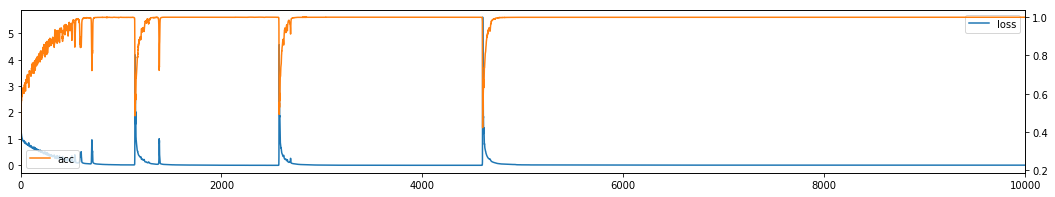

time: 456 ms


In [48]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h7.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h7.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [49]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.99938433122979842

time: 410 ms


In [50]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[  30,    0,    0,    0,    0,    0,    0],
       [   0,  214,    0,    2,    0,    0,    0],
       [   0,    0, 2137,    1,    0,    0,    0],
       [   0,    0,    0, 2836,    0,    0,    0],
       [   0,    0,    1,    0, 1078,    0,    0],
       [   0,    0,    0,    0,    0,  193,    0],
       [   0,    0,    0,    0,    0,    0,    5]])

time: 40.7 ms


In [51]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        30
          1       1.00      0.99      1.00       216
          2       1.00      1.00      1.00      2138
          3       1.00      1.00      1.00      2836
          4       1.00      1.00      1.00      1079
          5       1.00      1.00      1.00       193
          6       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00      6497

time: 37.8 ms


# compare

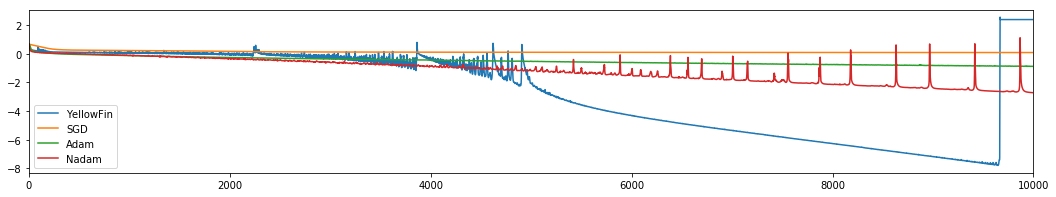

time: 589 ms


In [52]:
_ = pd.Series( np.log( h1.history[ 'loss' ] ), name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( np.log( h2.history[ 'loss' ] ), name='SGD' ).plot.line( legend=True )
_ = pd.Series( np.log( h3.history[ 'loss' ] ), name='Adam' ).plot.line( legend=True )
_ = pd.Series( np.log( h4.history[ 'loss' ] ), name='Nadam' ).plot.line( legend=True )

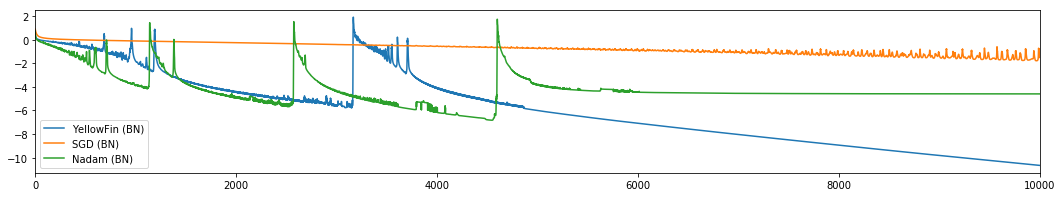

time: 503 ms


In [53]:
_ = pd.Series( np.log( h5.history[ 'loss' ] ), name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h6.history[ 'loss' ] ), name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h7.history[ 'loss' ] ), name='Nadam (BN)' ).plot.line( legend=True )

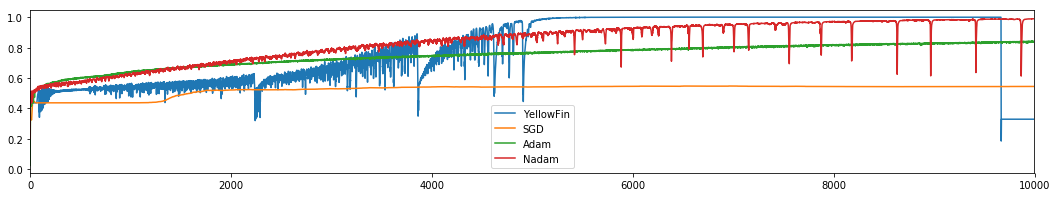

time: 680 ms


In [54]:
_ = pd.Series( h1.history[ 'acc' ], name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='SGD' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='Adam' ).plot.line( legend=True )
_ = pd.Series( h4.history[ 'acc' ], name='Nadam' ).plot.line( legend=True )

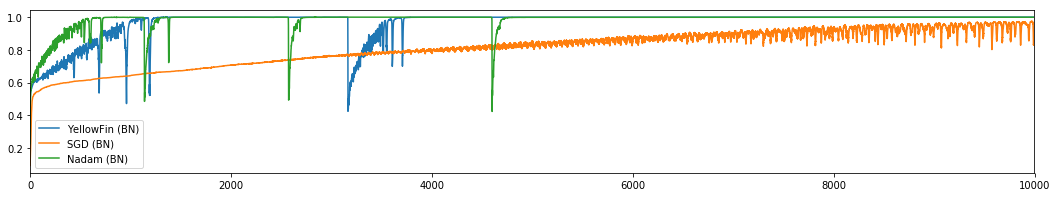

time: 511 ms


In [55]:
_ = pd.Series( h5.history[ 'acc' ], name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( h6.history[ 'acc' ], name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( h7.history[ 'acc' ], name='Nadam (BN)' ).plot.line( legend=True )